In [1]:
import mne
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from scipy.fft import fft
import os
import mne
import matplotlib.pyplot as plt
import numpy as np
from sklearn.svm import SVC

In [2]:
# Load all .bdf files from the folder
folder_path = 'data'
file_names = [f for f in os.listdir(folder_path) if f.endswith('.bdf')]

raw_list = []
# take only the first 4 files
for file_name in file_names[:3]:
    file_path = os.path.join(folder_path, file_name)
    raw = mne.io.read_raw_bdf(file_path, preload=True)
    raw_list.append(raw)

# Concatenate all the raw objects
raw_concatenated = mne.concatenate_raws(raw_list)

# Find events in the concatenated data
events = mne.find_events(raw_concatenated)

Extracting EDF parameters from c:\Users\hubra\Documents\machine-perception\data\eeg_recording_1.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1155327  =      0.000 ...  4512.996 secs...
Extracting EDF parameters from c:\Users\hubra\Documents\machine-perception\data\eeg_recording_2.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1407231  =      0.000 ...  5496.996 secs...
Extracting EDF parameters from c:\Users\hubra\Documents\machine-perception\data\eeg_recording_3.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 1268479  =      0.000 ...  4954.996 secs...
Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
228 events found
Event IDs: [    1     2     3     4     5     6     7     8     9    10    11    12
 

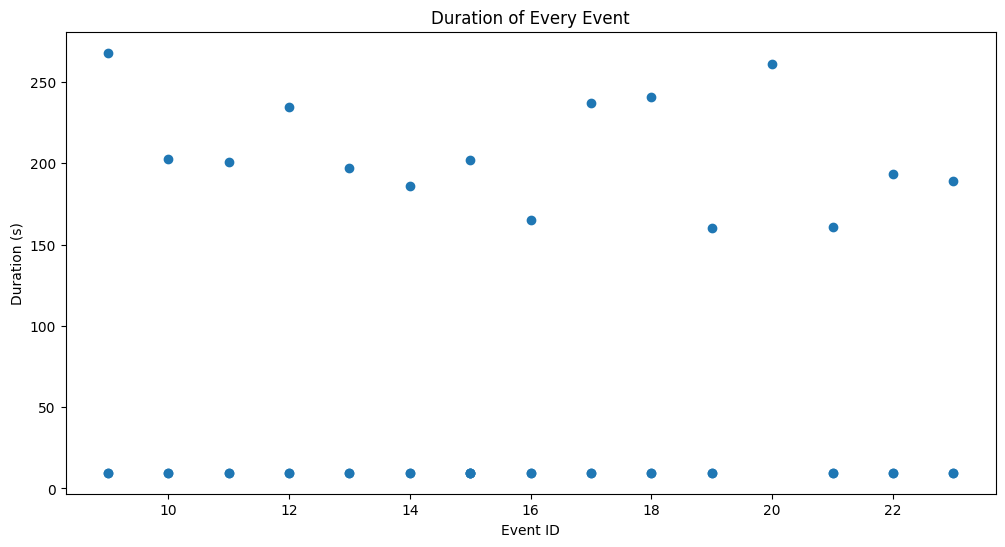

In [3]:
# Calculate the duration of each event
durations = []
for i in range(1, len(events)):
    start_time_current_event = events[i - 1, 0]
    start_time_next_event = events[i, 0]
    duration = (start_time_next_event - start_time_current_event) / raw_concatenated.info['sfreq']
    event_id = events[i - 1, 2]
    if event_id >= 9 and event_id <= 23:
        durations.append((event_id, duration))

# Plot the duration of every event
event_ids, event_durations = zip(*durations)
plt.figure(figsize=(12, 6))
plt.scatter(event_ids, event_durations)
plt.xlabel('Event ID')
plt.ylabel('Duration (s)')
plt.title('Duration of Every Event')
plt.show()

In [4]:
raw = raw_concatenated

print(raw.info)

print('Number of channels:', len(raw.ch_names))
print('Sampling rate:', raw.info['sfreq'], 'Hz')
print('Duration:', raw.n_times / raw.info['sfreq'], 'seconds')


<Info | 7 non-empty values
 bads: []
 ch_names: 1A1, 1A2, 1A3, 1A4, 1A5, 1A6, 1A7, 1A8, 1A9, 1A10, 1A11, 1A12, ...
 chs: 264 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 67.0 Hz
 meas_date: 2004-05-12 11:59:54 UTC
 nchan: 265
 projs: []
 sfreq: 256.0 Hz
>
Number of channels: 265
Sampling rate: 256.0 Hz
Duration: 14965.0 seconds


In [5]:
events = mne.find_events(raw)
event_id = {'awe': 9, 
            'frustration': 10,
            'joy': 11,
            'anger': 12,
            'happy': 13,
            'sad': 14,
            'love': 15,
            'fear': 16,
            'compassion': 17,
            'jealousy': 18,
            'content': 19,
            'grief': 20,
            'relief': 21,
            'excite': 22,
            'disgust': 23
            }
epochs = mne.Epochs(raw, events, event_id, tmin=-0.2, tmax=0.5, baseline=None)

X = epochs.get_data()
y = epochs.events[:, -1]

Trigger channel has a non-zero initial value of 65536 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
228 events found
Event IDs: [    1     2     3     4     5     6     7     8     9    10    11    12
    13    14    15    16    17    18    19    20    21    22    23    24
    25    26    30   100 65536 65540]
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 180 original time points ...
0 bad epochs dropped


In [7]:
X.shape, y.shape

((45, 265, 180), (45,))

In [8]:
def extend_data(X, y, n_segments = 8):
    extended_X = []
    extended_y = []

    # Divide each epoch into smaller segments and extend the data and labels
    for epoch, label in zip(X, y):
        segment_duration = epoch.shape[1] // n_segments
        for i in range(n_segments):
            start = i * segment_duration
            end = start + segment_duration
            segment = epoch[:, start:end]
            extended_X.append(segment)
            extended_y.append(label)

    extended_X = np.array(extended_X)
    extended_y = np.array(extended_y)
    return extended_X, extended_y

In [9]:
extended_X, extended_y = extend_data(X, y)
extended_X.shape, extended_y.shape

((360, 265, 22), (360,))

In [10]:
def test_all_classifiers(X, y):
    # Train and test the classifier using stratified sampling
    X_train, X_test, y_train, y_test = train_test_split(X.reshape(X.shape[0], -1), y, test_size=0.3, random_state=42, stratify=y)

    # Logistic Regression
    pipeline = make_pipeline(
        StandardScaler(),
        LogisticRegression()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Logistic Regression accuracy: {accuracy:.2f}')

    # Support Vector Classification
    pipeline = make_pipeline(
        StandardScaler(),
        SVC()
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'SVC accuracy: {accuracy:.2f}')

In [11]:
test_all_classifiers(extended_X, extended_y)

C:\Users\hubra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.86
SVC accuracy: 0.25


In [12]:
# Define a function to compute the power spectral density (PSD)
def compute_psd(epochs, freq_bands, sfreq):
    psd_list = []

    for epoch in epochs:
        psd = np.abs(fft(epoch))**2
        psd_freqs = np.fft.fftfreq(epoch.shape[-1], 1 / sfreq)
        
        band_powers = []
        for band in freq_bands:
            idx = np.logical_and(psd_freqs >= band[0], psd_freqs <= band[1])
            band_power = np.sum(psd[:, idx], axis=-1)
            band_powers.append(band_power)
            
        psd_list.append(np.array(band_powers))

    return np.array(psd_list)

In [13]:
# Define the frequency bands of interest
freq_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 45),
}

X_psd = compute_psd(epochs, freq_bands.values(), epochs.info['sfreq'])

In [14]:
X_psd.shape

(45, 5, 265)

In [15]:
extended_X_psd, extended_y = extend_data(X_psd, y)
extended_X_psd.shape, extended_y.shape

((360, 5, 33), (360,))

In [16]:
test_all_classifiers(extended_X_psd, extended_y)

Logistic Regression accuracy: 0.13
SVC accuracy: 0.12


C:\Users\hubra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [17]:
extended_X = extended_X.reshape(extended_X.shape[0], -1)
extended_X_psd = extended_X_psd.reshape(extended_X_psd.shape[0], -1)
extended_X_combined = np.concatenate((extended_X, extended_X_psd), axis=1)

In [18]:
extended_X.shape, extended_X_psd.shape

((360, 5830), (360, 165))

In [19]:
test_all_classifiers(extended_X_combined, extended_y)

C:\Users\hubra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression accuracy: 0.78
SVC accuracy: 0.27
